In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

df = pd.read_csv('PBP2324.csv')
df.head()

,game_id,date,home,away,play_id,half,time_remaining_half,secs_remaining,secs_remaining_absolute,description,...,arena_location,arena,attendance,shot_team,shot_outcome,shooter,three_pt,free_throw,possession_before,possession_after
0,401604781,2023-11-07,Texas A&M-CC,SW Adventist,1,1,19:38,2378,2378,Jason Garcia missed Layup.,...,"Corpus Christi, TX",Dugan Wellness Center,1400,SW Adventist,missed,Jason Garcia,False,False,SW Adventist,Texas A&M-CC
1,401604781,2023-11-07,Texas A&M-CC,SW Adventist,2,1,19:35,2375,2375,Garry Clark Defensive Rebound.,...,"Corpus Christi, TX",Dugan Wellness Center,1400,NaN,NaN,NaN,NaN,NaN,SW Adventist,Texas A&M-CC
2,401604781,2023-11-07,Texas A&M-CC,SW Adventist,3,1,19:24,2364,2364,Jordan Roberts made Three Point Jumper. Assist...,...,"Corpus Christi, TX",Dugan Wellness Center,1400,Texas A&M-CC,made,Jordan Roberts,True,False,Texas A&M-CC,SW Adventist
3,401604781,2023-11-07,Texas A&M-CC,SW Adventist,4,1,18:59,2339,2339,Ephraim Viadex Turnover.,...,"Corpus Christi, TX",Dugan Wellness Center,1400,NaN,NaN,NaN,NaN,NaN,SW Adventist,Texas A&M-CC
4,401604781,2023-11-07,Texas A&M-CC,SW Adventist,5,1,18:59,2339,2339,Garry Clark Steal.,...,"Corpus Christi, TX",Dugan Wellness Center,1400,NaN,NaN,NaN,NaN,NaN,SW Adventist,Texas A&M-CC


In [2]:
games_and_dates = df[['game_id', 'date', 'home', 'away']].drop_duplicates()
games_and_dates["date"] = pd.to_datetime(games_and_dates["date"])
# combine the home and away teams into a single column, but two rows per game
games_and_dates = pd.melt(games_and_dates, id_vars=['game_id', 'date'], value_vars=['home', 'away'], 
                    var_name='home_away', value_name='team')
games_and_dates.drop(columns=['home_away'], inplace=True)
games_and_dates.sort_values(by=['team', 'date'], inplace=True)
games_and_dates['rest_days'] = games_and_dates.groupby('team')['date'].diff().dt.days - 1
games_and_dates

,game_id,date,team,rest_days
11465,401600143,2023-12-30,ANTELOPE,NaN
11872,401592097,2023-12-10,AR-Fort Smith,NaN
6377,401594537,2023-11-06,AR-Pine Bluff,NaN
377,401604754,2023-11-09,AR-Pine Bluff,2.0
378,401611838,2023-11-11,AR-Pine Bluff,1.0
...,...,...,...,...
7428,401587744,2024-02-17,Youngstown St,2.0
10008,401587749,2024-02-23,Youngstown St,5.0
8734,401587754,2024-02-25,Youngstown St,1.0
1903,401587756,2024-02-28,Youngstown St,2.0


<Axes: >

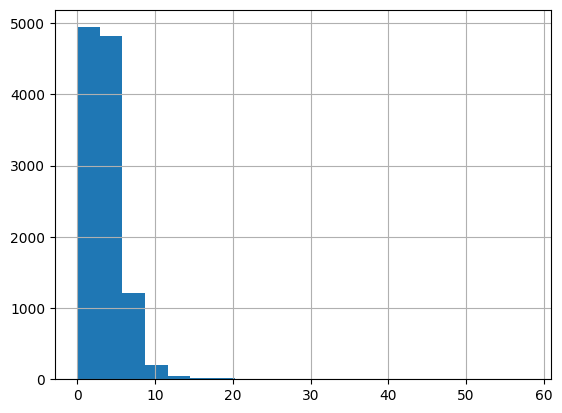

In [3]:
games_and_dates.rest_days.hist(bins=20)

In [4]:
games_and_dates.isna().sum()

game_id        0
date           0
team           0
rest_days    706
dtype: int64

In [5]:
# Fill the NaN values with median rest days of the team, if the team has played at least one game, otherwise median rest days of all teams
median_rest_days = games_and_dates.groupby('team')['rest_days'].median()
median_rest_days.fillna(games_and_dates['rest_days'].median(), inplace=True)
median_rest_days = median_rest_days.astype(int)
games_and_dates['rest_days'] = games_and_dates['rest_days'].fillna(games_and_dates['team'].map(median_rest_days))
games_and_dates.isna().sum()

game_id      0
date         0
team         0
rest_days    0
dtype: int64

In [6]:
games_and_dates[games_and_dates['game_id'] == 401604781]

,game_id,date,team,rest_days
6001,401604781,2023-11-07,SW Adventist,0.0
0,401604781,2023-11-07,Texas A&M-CC,3.0


In [7]:
games_and_dates.drop(columns=['date'], inplace=True)

In [8]:
games_and_dates.set_index(['game_id', 'team'], inplace=True)

## Feature Engineering

In [9]:
df = df.merge(games_and_dates.rename(columns={"rest_days": "home_rest_days"}), left_on=['game_id', 'home'], right_on=['game_id', 'team'], how='left')
df = df.merge(games_and_dates.rename(columns={"rest_days": "away_rest_days"}), left_on=['game_id', 'away'], right_on=['game_id', 'team'], how='left')
df.head()

,game_id,date,home,away,play_id,half,time_remaining_half,secs_remaining,secs_remaining_absolute,description,...,attendance,shot_team,shot_outcome,shooter,three_pt,free_throw,possession_before,possession_after,home_rest_days,away_rest_days
0,401604781,2023-11-07,Texas A&M-CC,SW Adventist,1,1,19:38,2378,2378,Jason Garcia missed Layup.,...,1400,SW Adventist,missed,Jason Garcia,False,False,SW Adventist,Texas A&M-CC,3.0,0.0
1,401604781,2023-11-07,Texas A&M-CC,SW Adventist,2,1,19:35,2375,2375,Garry Clark Defensive Rebound.,...,1400,NaN,NaN,NaN,NaN,NaN,SW Adventist,Texas A&M-CC,3.0,0.0
2,401604781,2023-11-07,Texas A&M-CC,SW Adventist,3,1,19:24,2364,2364,Jordan Roberts made Three Point Jumper. Assist...,...,1400,Texas A&M-CC,made,Jordan Roberts,True,False,Texas A&M-CC,SW Adventist,3.0,0.0
3,401604781,2023-11-07,Texas A&M-CC,SW Adventist,4,1,18:59,2339,2339,Ephraim Viadex Turnover.,...,1400,NaN,NaN,NaN,NaN,NaN,SW Adventist,Texas A&M-CC,3.0,0.0
4,401604781,2023-11-07,Texas A&M-CC,SW Adventist,5,1,18:59,2339,2339,Garry Clark Steal.,...,1400,NaN,NaN,NaN,NaN,NaN,SW Adventist,Texas A&M-CC,3.0,0.0


In [10]:
df["points"] = (df['shot_outcome'] == 'made') * (df['three_pt'] * 3 + (1 - df['three_pt']) * 2)
df.head()

,game_id,date,home,away,play_id,half,time_remaining_half,secs_remaining,secs_remaining_absolute,description,...,shot_team,shot_outcome,shooter,three_pt,free_throw,possession_before,possession_after,home_rest_days,away_rest_days,points
0,401604781,2023-11-07,Texas A&M-CC,SW Adventist,1,1,19:38,2378,2378,Jason Garcia missed Layup.,...,SW Adventist,missed,Jason Garcia,False,False,SW Adventist,Texas A&M-CC,3.0,0.0,0
1,401604781,2023-11-07,Texas A&M-CC,SW Adventist,2,1,19:35,2375,2375,Garry Clark Defensive Rebound.,...,NaN,NaN,NaN,NaN,NaN,SW Adventist,Texas A&M-CC,3.0,0.0,NaN
2,401604781,2023-11-07,Texas A&M-CC,SW Adventist,3,1,19:24,2364,2364,Jordan Roberts made Three Point Jumper. Assist...,...,Texas A&M-CC,made,Jordan Roberts,True,False,Texas A&M-CC,SW Adventist,3.0,0.0,3
3,401604781,2023-11-07,Texas A&M-CC,SW Adventist,4,1,18:59,2339,2339,Ephraim Viadex Turnover.,...,NaN,NaN,NaN,NaN,NaN,SW Adventist,Texas A&M-CC,3.0,0.0,NaN
4,401604781,2023-11-07,Texas A&M-CC,SW Adventist,5,1,18:59,2339,2339,Garry Clark Steal.,...,NaN,NaN,NaN,NaN,NaN,SW Adventist,Texas A&M-CC,3.0,0.0,NaN


In [11]:
# Player Efficiency Rate
player_stats = df.groupby('shooter').agg({'points': 'sum', 'play_id': 'count'})
player_stats['PER'] = player_stats['points'] / player_stats['play_id']
player_stats.drop(['points', 'play_id'], axis=1, inplace=True)

In [12]:
shot_counts = df.groupby('shooter')['shot_outcome'].count()
made_shots = df[df['shot_outcome'] == 'made'].groupby('shooter')['shot_outcome'].count()
field_goal_percentage = made_shots / shot_counts

In [13]:
three_pointers = df[df['three_pt'] == 1].groupby('shooter')['shot_outcome'].count()
three_point_percentage = three_pointers / shot_counts

In [14]:
free_throws = df[df['free_throw'] == 1].groupby('shooter')['shot_outcome'].count()
free_throw_percentage = free_throws / shot_counts

In [15]:
player_stats["FG_pct"] = field_goal_percentage
player_stats["3P_pct"] = three_point_percentage
player_stats["FT_pct"] = free_throw_percentage
player_stats

,PER,FG_pct,3P_pct,FT_pct
shooter,,,,
,0.5,0.250000,0.250000,0.312500
A'lahn Sumler,1.042129,0.456763,0.394678,0.175166
A.J. Hoggard,1.07971,0.512077,0.164251,0.256039
A.J. Lopez,1.121212,0.506494,0.329004,0.225108
A.J. Neal,0.955414,0.401274,0.458599,0.184713
...,...,...,...,...
Zvonimir Ivisic,1.352113,0.633803,0.225352,0.281690
Zy'Nyia White,1.1,0.500000,0.200000,0.400000
Zyeir Lawrence,0.5,0.250000,NaN,0.375000


In [16]:
# clustch shots
clutch_shots = df[(df['secs_remaining_absolute'] <= 120) & (abs(df['score_diff']) <= 5)]  # Define clutch situations
print(clutch_shots.shot_outcome.value_counts())
clutch_made = clutch_shots[clutch_shots['shot_outcome'] == 'made'].groupby('shooter')['shot_outcome'].count()
clutch_attempts = clutch_shots.groupby('shooter')['shot_outcome'].count()

clutch_percentage = clutch_made / clutch_attempts
player_stats['clutch_pct'] = clutch_percentage
player_stats.fillna(0, inplace=True)

player_stats

shot_outcome
made      12841
missed     9265
Name: count, dtype: int64


,PER,FG_pct,3P_pct,FT_pct,clutch_pct
shooter,,,,,
,0.5,0.250000,0.250000,0.312500,0.000000
A'lahn Sumler,1.042129,0.456763,0.394678,0.175166,0.692308
A.J. Hoggard,1.07971,0.512077,0.164251,0.256039,0.722222
A.J. Lopez,1.121212,0.506494,0.329004,0.225108,0.500000
A.J. Neal,0.955414,0.401274,0.458599,0.184713,0.571429
...,...,...,...,...,...
Zvonimir Ivisic,1.352113,0.633803,0.225352,0.281690,0.000000
Zy'Nyia White,1.1,0.500000,0.200000,0.400000,0.000000
Zyeir Lawrence,0.5,0.250000,0.000000,0.375000,0.000000


In [17]:
# Team Performance
# Create separate DataFrames for home and away games
home_games = df[df['action_team'] == 'home']
away_games = df[df['action_team'] == 'away']

In [18]:
# Calculate points and plays for home games
home_team_points = home_games.groupby('home')['points'].sum()
home_team_plays = home_games.groupby('home')['play_id'].count()
home_team_performance = home_team_points / home_team_plays
home_team_performance

home
AR-Pine Bluff     0.619503
Abilene Chrstn    0.570608
Air Force         0.542373
Akron             0.564856
Alabama            0.63105
                    ...   
Wright St         0.658087
Wyoming           0.603371
Xavier            0.558805
Yale              0.578699
Youngstown St     0.601592
Length: 364, dtype: object

In [19]:
# Calculate points and plays for away games
away_team_points = away_games.groupby('away')['points'].sum()
away_team_plays = away_games.groupby('away')['play_id'].count()
away_team_performance = away_team_points / away_team_plays
away_team_performance

away
ANTELOPE           0.49711
AR-Fort Smith     0.448052
AR-Pine Bluff      0.59605
AVILA             0.429967
Abilene Chrstn    0.512095
                    ...   
Xavier            0.535842
Xavier LA         0.425325
YORKCOLNEB        0.516556
Yale              0.557805
Youngstown St     0.536226
Length: 705, dtype: object

In [20]:
# Commpute team performance as mean of home and away performance, if any team has only home or away games, use that
team_performance = (home_team_performance + away_team_performance) / 2
team_performance = team_performance.fillna(home_team_performance).fillna(away_team_performance)
team_performance

/var/folders/9q/_q4q_3y536j3lx6cc49vl0840000gn/T/ipykernel_99081/1450130376.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  team_performance = team_performance.fillna(home_team_performance).fillna(away_team_performance)


ANTELOPE          0.497110
AR-Fort Smith     0.448052
AR-Pine Bluff     0.607776
AVILA             0.429967
Abilene Chrstn    0.541351
                    ...   
Xavier            0.547324
Xavier LA         0.425325
YORKCOLNEB        0.516556
Yale              0.568252
Youngstown St     0.568909
Length: 706, dtype: float64

In [21]:
# TODO: Consider rolling window later
df = df.merge(home_team_performance.rename('home_team_home_rating'), left_on='home', right_index=True, how='left')
df = df.merge(away_team_performance.rename('away_team_away_rating'), left_on='away', right_index=True, how='left')
df.head()

,game_id,date,home,away,play_id,half,time_remaining_half,secs_remaining,secs_remaining_absolute,description,...,shooter,three_pt,free_throw,possession_before,possession_after,home_rest_days,away_rest_days,points,home_team_home_rating,away_team_away_rating
0,401604781,2023-11-07,Texas A&M-CC,SW Adventist,1,1,19:38,2378,2378,Jason Garcia missed Layup.,...,Jason Garcia,False,False,SW Adventist,Texas A&M-CC,3.0,0.0,0,0.525312,0.444444
1,401604781,2023-11-07,Texas A&M-CC,SW Adventist,2,1,19:35,2375,2375,Garry Clark Defensive Rebound.,...,NaN,NaN,NaN,SW Adventist,Texas A&M-CC,3.0,0.0,NaN,0.525312,0.444444
2,401604781,2023-11-07,Texas A&M-CC,SW Adventist,3,1,19:24,2364,2364,Jordan Roberts made Three Point Jumper. Assist...,...,Jordan Roberts,True,False,Texas A&M-CC,SW Adventist,3.0,0.0,3,0.525312,0.444444
3,401604781,2023-11-07,Texas A&M-CC,SW Adventist,4,1,18:59,2339,2339,Ephraim Viadex Turnover.,...,NaN,NaN,NaN,SW Adventist,Texas A&M-CC,3.0,0.0,NaN,0.525312,0.444444
4,401604781,2023-11-07,Texas A&M-CC,SW Adventist,5,1,18:59,2339,2339,Garry Clark Steal.,...,NaN,NaN,NaN,SW Adventist,Texas A&M-CC,3.0,0.0,NaN,0.525312,0.444444


In [22]:
# Get one row per game id with secs remaining = 0 and see which team won
game_wins = df[df["secs_remaining"] == 0].groupby('game_id').agg({'score_diff': 'last'})
game_wins['winner'] = (game_wins['score_diff'] > 0) * 1
game_wins = game_wins.reset_index()
game_wins

,game_id,score_diff,winner
0,401573353,10,1
1,401573354,-14,0
2,401573355,-4,0
3,401573356,4,1
4,401573357,-7,0
...,...,...,...
5809,401634067,20,1
5810,401634068,-1,0
5811,401634069,13,1
5812,401634070,5,1


In [23]:
# Merge the dataframes
home_wins = game_wins.merge(home_games[["game_id", "home"]].drop_duplicates(), on='game_id', how='left')

# Calculate total games played by each team at home
total_home_games = home_wins.groupby('home')['game_id'].count()

# Calculate total wins by each team at home
home_wins = home_wins.groupby('home')['winner'].sum()

# Calculate win percentage
home_win_percentage = (home_wins / total_home_games) * 100 
home_win_percentage

home
AR-Pine Bluff     61.538462
Abilene Chrstn    57.142857
Air Force         25.000000
Akron             78.947368
Alabama           83.333333
                    ...    
Wright St         52.941176
Wyoming           58.823529
Xavier            57.894737
Yale              81.818182
Youngstown St     80.000000
Length: 364, dtype: float64

In [24]:
# Merge the dataframes
away_wins = game_wins.merge(away_games[["game_id", "away"]].drop_duplicates(), on='game_id', how='left')

# Calculate total games played by each team at home
total_away_games = away_wins.groupby('away')['game_id'].count()

# Calculate total wins by each team at home
away_wins = away_wins.groupby('away')['winner'].sum()

# Calculate win percentage
away_win_percentage = (away_wins / total_away_games) * 100 
away_win_percentage

away
ANTELOPE          100.000000
AR-Fort Smith     100.000000
AR-Pine Bluff      64.285714
AVILA             100.000000
Abilene Chrstn     71.428571
                     ...    
Xavier             64.285714
Xavier LA         100.000000
YORKCOLNEB        100.000000
Yale               43.750000
Youngstown St      50.000000
Length: 691, dtype: float64

In [25]:
df = df.merge(home_win_percentage.rename('home_team_home_win_percentage'), left_on='home', right_index=True, how='left')
df = df.merge(away_win_percentage.rename('away_team_away_win_percentage'), left_on='away', right_index=True, how='left')
df.head()

,game_id,date,home,away,play_id,half,time_remaining_half,secs_remaining,secs_remaining_absolute,description,...,free_throw,possession_before,possession_after,home_rest_days,away_rest_days,points,home_team_home_rating,away_team_away_rating,home_team_home_win_percentage,away_team_away_win_percentage
0,401604781,2023-11-07,Texas A&M-CC,SW Adventist,1,1,19:38,2378,2378,Jason Garcia missed Layup.,...,False,SW Adventist,Texas A&M-CC,3.0,0.0,0,0.525312,0.444444,71.428571,100.0
1,401604781,2023-11-07,Texas A&M-CC,SW Adventist,2,1,19:35,2375,2375,Garry Clark Defensive Rebound.,...,NaN,SW Adventist,Texas A&M-CC,3.0,0.0,NaN,0.525312,0.444444,71.428571,100.0
2,401604781,2023-11-07,Texas A&M-CC,SW Adventist,3,1,19:24,2364,2364,Jordan Roberts made Three Point Jumper. Assist...,...,False,Texas A&M-CC,SW Adventist,3.0,0.0,3,0.525312,0.444444,71.428571,100.0
3,401604781,2023-11-07,Texas A&M-CC,SW Adventist,4,1,18:59,2339,2339,Ephraim Viadex Turnover.,...,NaN,SW Adventist,Texas A&M-CC,3.0,0.0,NaN,0.525312,0.444444,71.428571,100.0
4,401604781,2023-11-07,Texas A&M-CC,SW Adventist,5,1,18:59,2339,2339,Garry Clark Steal.,...,NaN,SW Adventist,Texas A&M-CC,3.0,0.0,NaN,0.525312,0.444444,71.428571,100.0


In [26]:
df.dropna(subset=['shooter'], inplace=True)

In [27]:
# Drop specified columns
columns_to_drop = ['date', 'play_id', 'half',
                   'time_remaining_half', 'secs_remaining_absolute', 'description',
                   'play_length', 'scoring_play', 'foul', 'referees',
                   'arena_location', 'arena', 'attendance', 'possession_before',
                   'possession_after', 'shot_team', 'shot_outcome']
df.drop(columns=columns_to_drop, inplace=True)

In [28]:
df.columns

Index(['game_id', 'home', 'away', 'secs_remaining', 'action_team',
       'home_score', 'away_score', 'score_diff', 'win_prob', 'naive_win_prob',
       'home_time_out_remaining', 'away_time_out_remaining', 'home_favored_by',
       'total_line', 'shooter', 'three_pt', 'free_throw', 'home_rest_days',
       'away_rest_days', 'points', 'home_team_home_rating',
       'away_team_away_rating', 'home_team_home_win_percentage',
       'away_team_away_win_percentage'],
      dtype='object')

In [29]:
df["action_team"].value_counts()

action_team
home    475894
away    456220
Name: count, dtype: int64

In [30]:
temp_filter_columns = ['game_id', 'action_team', 'points', 'PER', 'FG_pct', '3P_pct', 'FT_pct', 'clutch_pct']

temp_df = df.merge(player_stats[['PER', 'FG_pct', '3P_pct', 'FT_pct', 'clutch_pct']], left_on='shooter', right_index=True, how='left')

game_wise_player_stats = temp_df[temp_filter_columns].drop_duplicates().groupby(['game_id', 'action_team']).agg(
            {
                # 'points': ['mean', 'max', 'median'], 
                'PER': ['mean', 'max', 'median'], 
                'FG_pct': ['mean', 'max', 'median'], 
                '3P_pct': ['mean', 'max', 'median'], 
                'FT_pct': ['mean', 'max', 'median'], 
                'clutch_pct': ['mean', 'max', 'median']}
             ).unstack()
game_wise_player_stats

PER                                                    \
                 mean                 max              median             
action_team      away      home      away      home      away      home   
game_id                                                                   
401573353    1.195221  1.278711   1.29703  1.392683  1.247036  1.264706   
401573354      1.1386  1.099737  1.264113  1.291803  1.163972  1.072727   
401573355    1.036346   1.14171  1.266667       2.0  1.091514  1.102484   
401573356    1.192284  1.173806  1.360248  1.266564  1.178082  1.168116   
401573357    1.118399  1.111051  1.318182  1.188713  1.097902   1.09434   
...               ...       ...       ...       ...       ...       ...   
401634067    1.134574  1.126772  1.246231  1.242105  1.125278  1.123934   
401634068    1.095032   1.12121  1.365854  1.229665  1.094488  1.135135   
401634069    1.180533  1.148721  1.326409  1.308642  1.173585  1.127371   
401634070     1.17603  1.118986  1.473684  1.246612  1.170732  1.100917   
401636059    1.128188  1.122508  1.290102  1.186813  1.127371  1.135501   

               FG_pct                                ...    FT_pct            \
                 mean                 max            ...       max             
action_team      away      home      away      home  ...      away      home   
game_id                                              ...                       
401573353    0.546876  0.586411  0.648515  0.635659  ...  0.352273  0.495475   
401573354    0.507972  0.501345  0.597403  0.616393  ...  0.296000  0.287958   
401573355    0.473713  0.533018  0.581114  1.000000  ...  0.320988  0.426471   
401573356    0.544934  0.532174  0.638629  0.607088  ...  0.445455  0.322034   
401573357    0.520815  0.521215  0.659091  0.584416  ...  0.419192  0.367876   
...               ...       ...       ...       ...  ...       ...       ...   
401634067    0.514723  0.522940  0.621429  0.621053  ...  0.385714  0.442105   
401634068    0.497969  0.499882  0.682927  0.567568  ...  0.328358  0.513514   
401634069    0.521557  0.496145  0.554896  0.641638  ...  0.303704  0.341297   
401634070    0.547030  0.514873  0.625000  0.623306  ...  0.318949  0.337302   
401636059    0.504514  0.509209  0.641638  0.583127  ...  0.352941  0.317618   

                                clutch_pct                                     \
               median                 mean                 max         median   
action_team      away      home       away      home      away home      away   
game_id                                                                         
401573353    0.230380  0.274011   0.546667  0.647950  1.000000  1.0  0.666667   
401573354    0.259740  0.227273   0.492682  0.450510  0.700000  1.0  0.575758   
401573355    0.180157  0.241558   0.481137  0.568885  1.000000  1.0  0.500000   
401573356    0.223602  0.268139   0.607907  0.618266  1.000000  1.0  0.652174   
401573357    0.341121  0.311538   0.448413  0.497199  0.714286  1.0  0.611111   
...               ...       ...        ...       ...       ...  ...       ...   
401634067    0.217647  0.248092   0.367965  0.568154  0.666667  1.0  0.500000   
401634068    0.191950  0.193548   0.408403  0.522511  0.666667  1.0  0.500000   
401634069    0.253937  0.193703   0.431046  0.470769  0.666667  1.0  0.558824   
401634070    0.252049  0.244240   0.540882  0.460823  0.818182  1.0  0.565217   
401636059    0.205962  0.199866   0.464719  0.542929  0.857143  1.0  0.500000   

                       
                       
action_team      home  
game_id                
401573353    0.666667  
401573354    0.500000  
401573355    0.571429  
401573356    0.666667  
401573357    0.428571  
...               ...  
401634067    0.598039  
401634068    0.545455  
401634069    0.500000  
401634070    0.500000  
401636059    0.595960  

[6001 rows x 30 columns]

In [31]:
game_wise_player_stats.columns = ['_'.join(col).strip() for col in game_wise_player_stats.columns.values]
game_wise_player_stats

,PER_mean_away,PER_mean_home,PER_max_away,PER_max_home,PER_median_away,PER_median_home,FG_pct_mean_away,FG_pct_mean_home,FG_pct_max_away,FG_pct_max_home,...,FT_pct_max_away,FT_pct_max_home,FT_pct_median_away,FT_pct_median_home,clutch_pct_mean_away,clutch_pct_mean_home,clutch_pct_max_away,clutch_pct_max_home,clutch_pct_median_away,clutch_pct_median_home
game_id,,,,,,,,,,,,,,,,,,,,,
401573353,1.195221,1.278711,1.29703,1.392683,1.247036,1.264706,0.546876,0.586411,0.648515,0.635659,...,0.352273,0.495475,0.230380,0.274011,0.546667,0.647950,1.000000,1.0,0.666667,0.666667
401573354,1.1386,1.099737,1.264113,1.291803,1.163972,1.072727,0.507972,0.501345,0.597403,0.616393,...,0.296000,0.287958,0.259740,0.227273,0.492682,0.450510,0.700000,1.0,0.575758,0.500000
401573355,1.036346,1.14171,1.266667,2.0,1.091514,1.102484,0.473713,0.533018,0.581114,1.000000,...,0.320988,0.426471,0.180157,0.241558,0.481137,0.568885,1.000000,1.0,0.500000,0.571429
401573356,1.192284,1.173806,1.360248,1.266564,1.178082,1.168116,0.544934,0.532174,0.638629,0.607088,...,0.445455,0.322034,0.223602,0.268139,0.607907,0.618266,1.000000,1.0,0.652174,0.666667
401573357,1.118399,1.111051,1.318182,1.188713,1.097902,1.09434,0.520815,0.521215,0.659091,0.584416,...,0.419192,0.367876,0.341121,0.311538,0.448413,0.497199,0.714286,1.0,0.611111,0.428571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401634067,1.134574,1.126772,1.246231,1.242105,1.125278,1.123934,0.514723,0.522940,0.621429,0.621053,...,0.385714,0.442105,0.217647,0.248092,0.367965,0.568154,0.666667,1.0,0.500000,0.598039
401634068,1.095032,1.12121,1.365854,1.229665,1.094488,1.135135,0.497969,0.499882,0.682927,0.567568,...,0.328358,0.513514,0.191950,0.193548,0.408403,0.522511,0.666667,1.0,0.500000,0.545455
401634069,1.180533,1.148721,1.326409,1.308642,1.173585,1.127371,0.521557,0.496145,0.554896,0.641638,...,0.303704,0.341297,0.253937,0.193703,0.431046,0.470769,0.666667,1.0,0.558824,0.500000


In [32]:
# Update PER for rows as per game id and action team
df = df.merge(game_wise_player_stats.reset_index(), on=['game_id'], how='left', validate='many_to_one')
df.head()

,game_id,home,away,secs_remaining,action_team,home_score,away_score,score_diff,win_prob,naive_win_prob,...,FT_pct_max_away,FT_pct_max_home,FT_pct_median_away,FT_pct_median_home,clutch_pct_mean_away,clutch_pct_mean_home,clutch_pct_max_away,clutch_pct_max_home,clutch_pct_median_away,clutch_pct_median_home
0,401604781,Texas A&M-CC,SW Adventist,2378,away,0,0,0,0.500000,0.500000,...,0.526316,0.420168,0.275,0.231084,0.0,0.195739,0.0,0.777778,0.0,0.0
1,401604781,Texas A&M-CC,SW Adventist,2364,home,3,0,3,0.566960,0.566960,...,0.526316,0.420168,0.275,0.231084,0.0,0.195739,0.0,0.777778,0.0,0.0
2,401604781,Texas A&M-CC,SW Adventist,2325,away,3,0,3,0.568216,0.568216,...,0.526316,0.420168,0.275,0.231084,0.0,0.195739,0.0,0.777778,0.0,0.0
3,401604781,Texas A&M-CC,SW Adventist,2313,home,3,0,3,0.568608,0.568608,...,0.526316,0.420168,0.275,0.231084,0.0,0.195739,0.0,0.777778,0.0,0.0
4,401604781,Texas A&M-CC,SW Adventist,2310,home,5,0,5,0.613242,0.613242,...,0.526316,0.420168,0.275,0.231084,0.0,0.195739,0.0,0.777778,0.0,0.0


In [33]:
# Temporatily drop null values
df.dropna(inplace=True)
100 * df.isna().sum() / df.shape[0]

game_id                          0.0
home                             0.0
away                             0.0
secs_remaining                   0.0
action_team                      0.0
home_score                       0.0
away_score                       0.0
score_diff                       0.0
win_prob                         0.0
naive_win_prob                   0.0
home_time_out_remaining          0.0
away_time_out_remaining          0.0
home_favored_by                  0.0
total_line                       0.0
shooter                          0.0
three_pt                         0.0
free_throw                       0.0
home_rest_days                   0.0
away_rest_days                   0.0
points                           0.0
home_team_home_rating            0.0
away_team_away_rating            0.0
home_team_home_win_percentage    0.0
away_team_away_win_percentage    0.0
PER_mean_away                    0.0
PER_mean_home                    0.0
PER_max_away                     0.0
P

In [34]:
df.head()

,game_id,home,away,secs_remaining,action_team,home_score,away_score,score_diff,win_prob,naive_win_prob,...,FT_pct_max_away,FT_pct_max_home,FT_pct_median_away,FT_pct_median_home,clutch_pct_mean_away,clutch_pct_mean_home,clutch_pct_max_away,clutch_pct_max_home,clutch_pct_median_away,clutch_pct_median_home
165,401575435,Houston,Texas A&M-CC,2383,home,0,0,0,0.995346,0.500000,...,0.420168,0.419355,0.255927,0.271071,0.289519,0.428508,0.777778,1.0,0.285714,0.375
166,401575435,Houston,Texas A&M-CC,2373,away,0,0,0,0.995320,0.500000,...,0.420168,0.419355,0.255927,0.271071,0.289519,0.428508,0.777778,1.0,0.285714,0.375
167,401575435,Houston,Texas A&M-CC,2368,away,0,2,-2,0.994391,0.455297,...,0.420168,0.419355,0.255927,0.271071,0.289519,0.428508,0.777778,1.0,0.285714,0.375
168,401575435,Houston,Texas A&M-CC,2327,home,0,2,-2,0.994239,0.454408,...,0.420168,0.419355,0.255927,0.271071,0.289519,0.428508,0.777778,1.0,0.285714,0.375
169,401575435,Houston,Texas A&M-CC,2305,away,0,2,-2,0.994153,0.453924,...,0.420168,0.419355,0.255927,0.271071,0.289519,0.428508,0.777778,1.0,0.285714,0.375


In [35]:
df.drop(columns=['home', 'away', 'shooter', 'win_prob', 'naive_win_prob', "home_favored_by", "total_line", 'three_pt', 'free_throw', 'points'], inplace=True)
df.sort_values(by=['game_id', 'secs_remaining'], ascending=[True, False], inplace=True)
df = df.groupby(['game_id']).last().reset_index(drop=True, inplace=False)
df

,secs_remaining,action_team,home_score,away_score,score_diff,home_time_out_remaining,away_time_out_remaining,home_rest_days,away_rest_days,home_team_home_rating,...,FT_pct_max_away,FT_pct_max_home,FT_pct_median_away,FT_pct_median_home,clutch_pct_mean_away,clutch_pct_mean_home,clutch_pct_max_away,clutch_pct_max_home,clutch_pct_median_away,clutch_pct_median_home
0,19,away,89,79,10,2,-5,4.0,4.0,0.688661,...,0.352273,0.495475,0.230380,0.274011,0.546667,0.647950,1.000000,1.0,0.666667,0.666667
1,20,home,48,62,-14,5,-3,4.0,4.0,0.52874,...,0.296000,0.287958,0.259740,0.227273,0.492682,0.450510,0.700000,1.0,0.575758,0.500000
2,0,away,88,92,-4,8,-12,4.0,4.0,0.556686,...,0.320988,0.426471,0.180157,0.241558,0.481137,0.568885,1.000000,1.0,0.500000,0.571429
3,1,home,85,81,4,7,-7,4.0,4.0,0.646916,...,0.445455,0.322034,0.223602,0.268139,0.607907,0.618266,1.000000,1.0,0.652174,0.666667
4,13,home,65,72,-7,6,-6,4.0,4.0,0.565199,...,0.419192,0.367876,0.341121,0.311538,0.448413,0.497199,0.714286,1.0,0.611111,0.428571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5102,12,away,73,53,20,6,-7,2.0,3.0,0.579055,...,0.385714,0.442105,0.217647,0.248092,0.367965,0.568154,0.666667,1.0,0.500000,0.598039
5103,0,home,81,82,-1,7,-10,2.0,3.0,0.573595,...,0.328358,0.513514,0.191950,0.193548,0.408403,0.522511,0.666667,1.0,0.500000,0.545455
5104,14,away,100,87,13,3,-4,2.0,3.0,0.637353,...,0.303704,0.341297,0.253937,0.193703,0.431046,0.470769,0.666667,1.0,0.558824,0.500000
5105,3,home,99,99,0,7,-10,2.0,3.0,0.57512,...,0.318949,0.337302,0.252049,0.244240,0.540882,0.460823,0.818182,1.0,0.565217,0.500000


In [36]:
# If score diff is positive, winner is 'home', else 'away'
df["winner"] = np.where(df["score_diff"] > 0, 'home', 'away')
df.head()

,secs_remaining,action_team,home_score,away_score,score_diff,home_time_out_remaining,away_time_out_remaining,home_rest_days,away_rest_days,home_team_home_rating,...,FT_pct_max_home,FT_pct_median_away,FT_pct_median_home,clutch_pct_mean_away,clutch_pct_mean_home,clutch_pct_max_away,clutch_pct_max_home,clutch_pct_median_away,clutch_pct_median_home,winner
0,19,away,89,79,10,2,-5,4.0,4.0,0.688661,...,0.495475,0.230380,0.274011,0.546667,0.647950,1.000000,1.0,0.666667,0.666667,home
1,20,home,48,62,-14,5,-3,4.0,4.0,0.52874,...,0.287958,0.259740,0.227273,0.492682,0.450510,0.700000,1.0,0.575758,0.500000,away
2,0,away,88,92,-4,8,-12,4.0,4.0,0.556686,...,0.426471,0.180157,0.241558,0.481137,0.568885,1.000000,1.0,0.500000,0.571429,away
3,1,home,85,81,4,7,-7,4.0,4.0,0.646916,...,0.322034,0.223602,0.268139,0.607907,0.618266,1.000000,1.0,0.652174,0.666667,home
4,13,home,65,72,-7,6,-6,4.0,4.0,0.565199,...,0.367876,0.341121,0.311538,0.448413,0.497199,0.714286,1.0,0.611111,0.428571,away


In [37]:
# df.drop(columns = ['game_id', 'home', 'away', 'shooter', 'win_prob', 'naive_win_prob', "home_favored_by", "total_line", 'three_pt', 'free_throw', 'points'], inplace=True)

In [38]:
df.shape

(5107, 44)

In [39]:
df = df[df["secs_remaining"] <= 120]
df.drop(columns=['secs_remaining'], inplace=True)

/var/folders/9q/_q4q_3y536j3lx6cc49vl0840000gn/T/ipykernel_99081/3164009476.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['secs_remaining'], inplace=True)


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5106 entries, 0 to 5106
Data columns (total 43 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   action_team                    5106 non-null   object 
 1   home_score                     5106 non-null   int64  
 2   away_score                     5106 non-null   int64  
 3   score_diff                     5106 non-null   int64  
 4   home_time_out_remaining        5106 non-null   int64  
 5   away_time_out_remaining        5106 non-null   int64  
 6   home_rest_days                 5106 non-null   float64
 7   away_rest_days                 5106 non-null   float64
 8   home_team_home_rating          5106 non-null   object 
 9   away_team_away_rating          5106 non-null   object 
 10  home_team_home_win_percentage  5106 non-null   float64
 11  away_team_away_win_percentage  5106 non-null   float64
 12  PER_mean_away                  5106 non-null   object

In [41]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# One-hot encode categorical features
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')
categorical_features = ['winner', 'action_team']
encoded_features = encoder.fit_transform(df[categorical_features])

for i, feature in enumerate(encoder.get_feature_names_out(categorical_features)):
    df[feature] = encoded_features[:, i]

df.drop(categorical_features, axis=1, inplace=True)

df

/var/folders/9q/_q4q_3y536j3lx6cc49vl0840000gn/T/ipykernel_99081/4089698608.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = encoded_features[:, i]
/var/folders/9q/_q4q_3y536j3lx6cc49vl0840000gn/T/ipykernel_99081/4089698608.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = encoded_features[:, i]
/var/folders/9q/_q4q_3y536j3lx6cc49vl0840000gn/T/ipykernel_99081/4089698608.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the

,home_score,away_score,score_diff,home_time_out_remaining,away_time_out_remaining,home_rest_days,away_rest_days,home_team_home_rating,away_team_away_rating,home_team_home_win_percentage,...,FT_pct_median_away,FT_pct_median_home,clutch_pct_mean_away,clutch_pct_mean_home,clutch_pct_max_away,clutch_pct_max_home,clutch_pct_median_away,clutch_pct_median_home,winner_home,action_team_home
0,89,79,10,2,-5,4.0,4.0,0.688661,0.597505,84.615385,...,0.230380,0.274011,0.546667,0.647950,1.000000,1.0,0.666667,0.666667,1.0,0.0
1,48,62,-14,5,-3,4.0,4.0,0.52874,0.572494,38.888889,...,0.259740,0.227273,0.492682,0.450510,0.700000,1.0,0.575758,0.500000,0.0,1.0
2,88,92,-4,8,-12,4.0,4.0,0.556686,0.509016,57.142857,...,0.180157,0.241558,0.481137,0.568885,1.000000,1.0,0.500000,0.571429,0.0,0.0
3,85,81,4,7,-7,4.0,4.0,0.646916,0.605203,80.000000,...,0.223602,0.268139,0.607907,0.618266,1.000000,1.0,0.652174,0.666667,1.0,1.0
4,65,72,-7,6,-6,4.0,4.0,0.565199,0.489707,60.000000,...,0.341121,0.311538,0.448413,0.497199,0.714286,1.0,0.611111,0.428571,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5102,73,53,20,6,-7,2.0,3.0,0.579055,0.535316,60.000000,...,0.217647,0.248092,0.367965,0.568154,0.666667,1.0,0.500000,0.598039,1.0,0.0
5103,81,82,-1,7,-10,2.0,3.0,0.573595,0.509419,42.857143,...,0.191950,0.193548,0.408403,0.522511,0.666667,1.0,0.500000,0.545455,0.0,1.0
5104,100,87,13,3,-4,2.0,3.0,0.637353,0.591189,73.333333,...,0.253937,0.193703,0.431046,0.470769,0.666667,1.0,0.558824,0.500000,1.0,0.0
5105,99,99,0,7,-10,2.0,3.0,0.57512,0.624436,89.473684,...,0.252049,0.244240,0.540882,0.460823,0.818182,1.0,0.565217,0.500000,0.0,1.0


In [42]:
100 * df.isna().sum() / df.shape[0]

home_score                       0.0
away_score                       0.0
score_diff                       0.0
home_time_out_remaining          0.0
away_time_out_remaining          0.0
home_rest_days                   0.0
away_rest_days                   0.0
home_team_home_rating            0.0
away_team_away_rating            0.0
home_team_home_win_percentage    0.0
away_team_away_win_percentage    0.0
PER_mean_away                    0.0
PER_mean_home                    0.0
PER_max_away                     0.0
PER_max_home                     0.0
PER_median_away                  0.0
PER_median_home                  0.0
FG_pct_mean_away                 0.0
FG_pct_mean_home                 0.0
FG_pct_max_away                  0.0
FG_pct_max_home                  0.0
FG_pct_median_away               0.0
FG_pct_median_home               0.0
3P_pct_mean_away                 0.0
3P_pct_mean_home                 0.0
3P_pct_max_away                  0.0
3P_pct_max_home                  0.0
3

In [43]:
numerical_features = df.select_dtypes(include=['number']).columns
numerical_features = numerical_features.drop(encoder.get_feature_names_out(categorical_features))
numerical_features

Index(['home_score', 'away_score', 'score_diff', 'home_time_out_remaining',
       'away_time_out_remaining', 'home_rest_days', 'away_rest_days',
       'home_team_home_win_percentage', 'away_team_away_win_percentage',
       'FG_pct_mean_away', 'FG_pct_mean_home', 'FG_pct_max_away',
       'FG_pct_max_home', 'FG_pct_median_away', 'FG_pct_median_home',
       '3P_pct_mean_away', '3P_pct_mean_home', '3P_pct_max_away',
       '3P_pct_max_home', '3P_pct_median_away', '3P_pct_median_home',
       'FT_pct_mean_away', 'FT_pct_mean_home', 'FT_pct_max_away',
       'FT_pct_max_home', 'FT_pct_median_away', 'FT_pct_median_home',
       'clutch_pct_mean_away', 'clutch_pct_mean_home', 'clutch_pct_max_away',
       'clutch_pct_max_home', 'clutch_pct_median_away',
       'clutch_pct_median_home'],
      dtype='object')

In [44]:
# Standardize the features
scaler = StandardScaler()

df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Display the first 5 rows
print(df.head().to_markdown(index=False, numalign="left", stralign="left"))

# Print the column names and their data types
print(df.info())

| home_score   | away_score   | score_diff   | home_time_out_remaining   | away_time_out_remaining   | home_rest_days   | away_rest_days   | home_team_home_rating   | away_team_away_rating   | home_team_home_win_percentage   | away_team_away_win_percentage   | PER_mean_away   | PER_mean_home   | PER_max_away   | PER_max_home   | PER_median_away   | PER_median_home   | FG_pct_mean_away   | FG_pct_mean_home   | FG_pct_max_away   | FG_pct_max_home   | FG_pct_median_away   | FG_pct_median_home   | 3P_pct_mean_away   | 3P_pct_mean_home   | 3P_pct_max_away   | 3P_pct_max_home   | 3P_pct_median_away   | 3P_pct_median_home   | FT_pct_mean_away   | FT_pct_mean_home   | FT_pct_max_away   | FT_pct_max_home   | FT_pct_median_away   | FT_pct_median_home   | clutch_pct_mean_away   | clutch_pct_mean_home   | clutch_pct_max_away   | clutch_pct_max_home   | clutch_pct_median_away   | clutch_pct_median_home   | winner_home   | action_team_home   |
|:-------------|:-------------|:-------------|:---------

/var/folders/9q/_q4q_3y536j3lx6cc49vl0840000gn/T/ipykernel_99081/887483885.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[numerical_features] = scaler.fit_transform(df[numerical_features])


In [45]:
100 * df.isna().sum() / df.shape[0]

home_score                       0.0
away_score                       0.0
score_diff                       0.0
home_time_out_remaining          0.0
away_time_out_remaining          0.0
home_rest_days                   0.0
away_rest_days                   0.0
home_team_home_rating            0.0
away_team_away_rating            0.0
home_team_home_win_percentage    0.0
away_team_away_win_percentage    0.0
PER_mean_away                    0.0
PER_mean_home                    0.0
PER_max_away                     0.0
PER_max_home                     0.0
PER_median_away                  0.0
PER_median_home                  0.0
FG_pct_mean_away                 0.0
FG_pct_mean_home                 0.0
FG_pct_max_away                  0.0
FG_pct_max_home                  0.0
FG_pct_median_away               0.0
FG_pct_median_home               0.0
3P_pct_mean_away                 0.0
3P_pct_mean_home                 0.0
3P_pct_max_away                  0.0
3P_pct_max_home                  0.0
3

In [46]:
df["winner_home"].value_counts()

winner_home
1.0    3247
0.0    1859
Name: count, dtype: int64

In [47]:
df.shape

(5106, 43)

In [48]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Separate features and target variable
X = df.drop(['winner_home', 'action_team_home', 'score_diff'], axis=1)
y = df['winner_home']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

# Initialize the RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42, n_jobs = 100, n_estimators=100)

# Fit the model on the training data
rf_classifier.fit(X_train, y_train)

# Predict on the testing data
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print('Classification Report:')
print(classification_report(y_test, y_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

# Get feature importances
feature_importances = rf_classifier.feature_importances_

# Print feature importances
print('Feature Importances:')
for i, feature in enumerate(X.columns):
    print(f'{feature}: {feature_importances[i]}')

Accuracy: 0.9315068493150684
Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.85      0.90       372
         1.0       0.92      0.98      0.95       650

    accuracy                           0.93      1022
   macro avg       0.94      0.92      0.92      1022
weighted avg       0.93      0.93      0.93      1022

Confusion Matrix:
[[318  54]
 [ 16 634]]
Feature Importances:
home_score: 0.2356681415577313
away_score: 0.18260076170445483
home_time_out_remaining: 0.006768227364423122
away_time_out_remaining: 0.009074942454386137
home_rest_days: 0.006489768511442789
away_rest_days: 0.007246040605726269
home_team_home_rating: 0.017516406845560883
away_team_away_rating: 0.016449675720373143
home_team_home_win_percentage: 0.06744036400263065
away_team_away_win_percentage: 0.05998993801116086
PER_mean_away: 0.020305531054941203
PER_mean_home: 0.015932454764653905
PER_max_away: 0.0107302574704837
PER_max_home: 0.017905846203537877


In [49]:
feat_importances_dict = dict(zip(X.columns, feature_importances))
feat_importances_dict = sorted(feat_importances_dict.items(), key=lambda x: x[1], reverse=True)

feat_importances_dict

[('home_score', 0.2356681415577313),
 ('away_score', 0.18260076170445483),
 ('home_team_home_win_percentage', 0.06744036400263065),
 ('away_team_away_win_percentage', 0.05998993801116086),
 ('FG_pct_mean_away', 0.02226086231116989),
 ('PER_mean_away', 0.020305531054941203),
 ('PER_max_home', 0.017905846203537877),
 ('home_team_home_rating', 0.017516406845560883),
 ('FG_pct_max_home', 0.01730312256868778),
 ('PER_median_home', 0.017030505265107056),
 ('FG_pct_median_home', 0.01662220424369058),
 ('away_team_away_rating', 0.016449675720373143),
 ('PER_mean_home', 0.015932454764653905),
 ('FG_pct_mean_home', 0.015250569768948438),
 ('FG_pct_median_away', 0.014458274406918216),
 ('clutch_pct_mean_away', 0.013677578484531584),
 ('clutch_pct_mean_home', 0.013648418840122167),
 ('PER_median_away', 0.013538315170897163),
 ('3P_pct_mean_home', 0.012818444771919388),
 ('FT_pct_mean_home', 0.012625607752137584),
 ('3P_pct_max_home', 0.012488642796845474),
 ('3P_pct_max_away', 0.012381797605527496

In [50]:
X_train = X_train.astype('float64')
X_test = X_test.astype('float64')

In [51]:
import xgboost as xgb

# Initialize the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(random_state=42, n_jobs=-1)

# Fit the model on the training data
xgb_classifier.fit(X_train, y_train)

# Predict on the testing data
y_pred = xgb_classifier.predict(X_test)

# Evaluate the model
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print('Classification Report:')
print(classification_report(y_test, y_pred))

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9823874755381604
Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98       372
         1.0       0.98      0.99      0.99       650

    accuracy                           0.98      1022
   macro avg       0.98      0.98      0.98      1022
weighted avg       0.98      0.98      0.98      1022

Confusion Matrix:
[[362  10]
 [  8 642]]


In [52]:
# from sklearn.svm import SVC

# # Initialize the SVM classifier
# svm_classifier = SVC(random_state=42)

# # Fit the model on the training data
# svm_classifier.fit(X_train, y_train)

# # Predict on the testing data
# y_pred = svm_classifier.predict(X_test)

# # Evaluate the model
# print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
# print('Classification Report:')
# print(classification_report(y_test, y_pred))

# print('Confusion Matrix:')
# print(confusion_matrix(y_test, y_pred))

Epoch 1/500


/Users/gvssriram/envs/bio_project_env/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5527 - auc: 0.5847 - loss: 1.6107 - precision: 0.7092 - recall: 0.5359 - val_accuracy: 0.6242 - val_auc: 0.6726 - val_loss: 1.5100 - val_precision: 0.6678 - val_recall: 0.7606 - learning_rate: 1.0000e-04
Epoch 2/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step - accuracy: 0.6448 - auc: 0.6546 - loss: 1.4957 - precision: 0.7173 - recall: 0.7486 - val_accuracy: 0.6854 - val_auc: 0.7421 - val_loss: 1.4309 - val_precision: 0.6807 - val_recall: 0.9095 - learning_rate: 1.0000e-04
Epoch 3/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step - accuracy: 0.6745 - auc: 0.6693 - loss: 1.4308 - precision: 0.7153 - recall: 0.8280 - val_accuracy: 0.7075 - val_auc: 0.7908 - val_loss: 1.3610 - val_precision: 0.6891 - val_recall: 0.9457 - learning_rate: 1.0000e-04
Epoch 4/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - accuracy: 0.7062 - auc: 0.7419 - loss: 1.3579 - precision: 0.7245 - recall: 0.8665 - val_accuracy: 0.7319 - val_auc: 0.8287 - val_loss: 1.

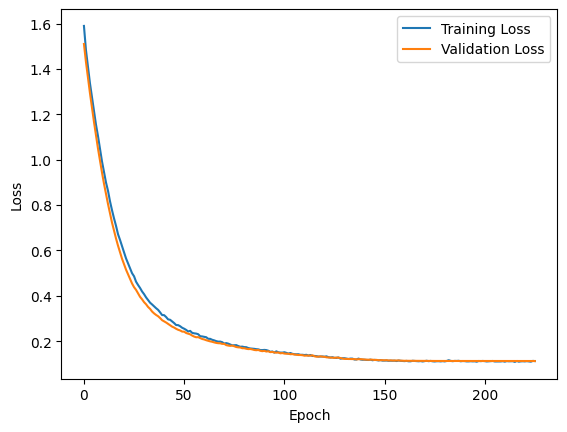

In [53]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define the neural network architecture
model = keras.Sequential([
    layers.Dense(64, activation='relu', kernel_regularizer='l2', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu', kernel_regularizer='l2'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model with additional metrics
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),
                       tf.keras.metrics.AUC()])

# Define Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Define Reduce Learning Rate on Plateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Fit the model with callbacks and validation data
history = model.fit(X_train, y_train,
                    epochs=500,  # Set a larger number of epochs
                    batch_size=32,
                    validation_split=0.2,  # Use a validation split for monitoring
                    callbacks=[early_stopping, reduce_lr])

# Predict on the testing data
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

# Evaluate the model
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print('Classification Report:')
print(classification_report(y_test, y_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

# Plot training history (optional)
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [54]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Fit the model on the training data
dt_classifier.fit(X_train, y_train)

# Predict on the testing data
y_pred = dt_classifier.predict(X_test)

# Evaluate the model
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print('Classification Report:')
print(classification_report(y_test, y_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.961839530332681
Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.95      0.95       372
         1.0       0.97      0.97      0.97       650

    accuracy                           0.96      1022
   macro avg       0.96      0.96      0.96      1022
weighted avg       0.96      0.96      0.96      1022

Confusion Matrix:
[[354  18]
 [ 21 629]]


In [55]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the LightGBM classifier
lgb_classifier = lgb.LGBMClassifier(random_state=42, n_jobs=-1, max_depth=10, n_estimators=300, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8, num_leaves=31)

# Fit the model on the training data
lgb_classifier.fit(X_train, y_train)

# Predict on the testing data
y_pred = lgb_classifier.predict(X_test)

# Evaluate the model
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print('Classification Report:')
print(classification_report(y_test, y_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

[LightGBM] [Info] Number of positive: 2597, number of negative: 1487
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000823 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7976
[LightGBM] [Info] Number of data points in the train set: 4084, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.635896 -> initscore=0.557596
[LightGBM] [Info] Start training from score 0.557596
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Accuracy: 0.9863013698630136
Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98       372
         1.0       0.98      0.99      0.99       650

    accuracy                           0.99      1022
   macro avg       0.99    

In [56]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the CatBoost classifier
catboost_classifier = CatBoostClassifier(random_state=42, verbose=0)  # Set verbose=0 to suppress training output

# Fit the model on the training data
catboost_classifier.fit(X_train, y_train)

# Predict on the testing data
y_pred = catboost_classifier.predict(X_test)

# Evaluate the model
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print('Classification Report:')
print(classification_report(y_test, y_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9794520547945206
Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.97       372
         1.0       0.98      0.99      0.98       650

    accuracy                           0.98      1022
   macro avg       0.98      0.98      0.98      1022
weighted avg       0.98      0.98      0.98      1022

Confusion Matrix:
[[359  13]
 [  8 642]]
